### 0. Import 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
import lightgbm as lgb



### 1. Load & Check Data

In [3]:
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')

app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print(app_train.shape)
print(app_test.shape)


(307511, 122)
(48744, 121)


- Distribution of Target Values 
    - 1 means 'default', else 0

In [5]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

- Check about column 'AMT_INCOME_TOTAL'

<Axes: >

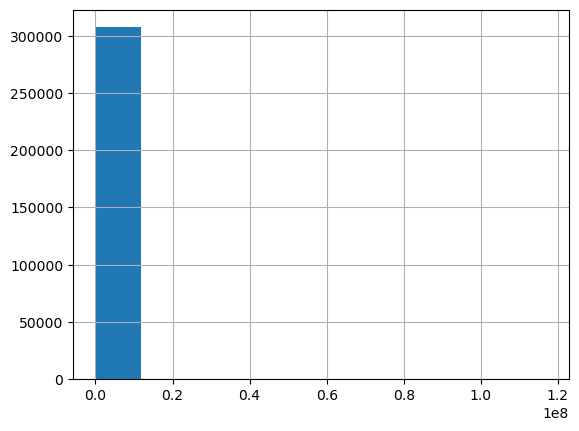

In [6]:
app_train['AMT_INCOME_TOTAL'].hist()
# This graph is not good for analysis because it is too much positively skewed

- Check about column 'AMT_INCOME_TOTAL' with filtered data AMT_INCOME_TOTAL < 1000000


<Axes: >

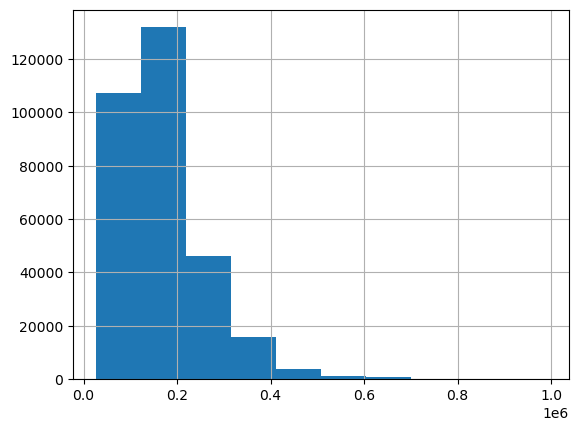

In [7]:
app_train[app_train['AMT_INCOME_TOTAL'] < 1000000]['AMT_INCOME_TOTAL'].hist()
# It seems like most datas are concentrated less than 500000

- Make a graph about column 'AMT_INCOME_TOTAL' with filtered data AMT_INCOME_TOTAL < 500000


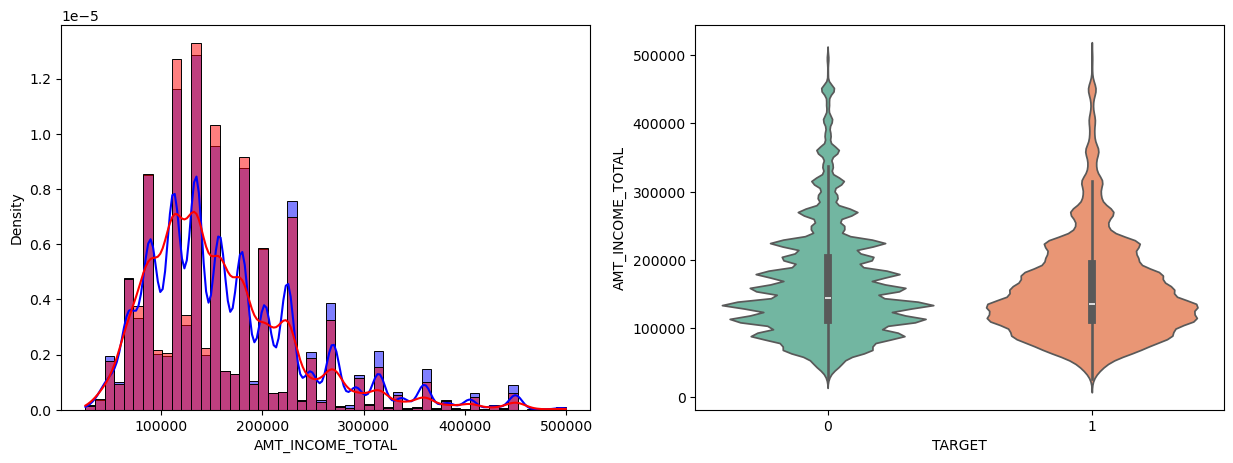

In [8]:
def show_column_hist(df, column_name :str, amt_limit=False):
    cond0  = df['TARGET'] == 0      
    cond1 = df['TARGET'] == 1   
    cond_amt = True

    fig, ax = plt.subplots(figsize=(15,5),nrows=1, ncols=2)
    if amt_limit == True:
        cond_amt = df[column_name] < 500000  
    
    sns.histplot(df[cond0 & cond_amt][column_name], stat='density', bins=50, kde=True, ax=ax[0], color='blue')
    sns.histplot(df[cond1 & cond_amt][column_name], stat='density', bins=50, kde=True, ax=ax[0],color='red')
    sns.violinplot(x='TARGET', y=column_name, data=df[cond_amt], ax=ax[1], palette='Set2')

show_column_hist(app_train,'AMT_INCOME_TOTAL',amt_limit=True)



#### 2. First Step 

1) Check important features with LightGBM.plot_importance

- concat app_train and app_test

In [9]:
apps = pd.concat([app_train,app_test],axis=0)
apps.shape

(356255, 122)

In [10]:
apps['TARGET'].value_counts(dropna=False)
# 48744 NaN Values 

TARGET
0.0    282686
NaN     48744
1.0     24825
Name: count, dtype: int64

- Select Object Features and Label Encoding 

In [10]:
object_columns = apps.dtypes[apps.dtypes=='object'].index.tolist()
object_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [11]:
for column in object_columns:
    apps[column] = pd.factorize(apps[column])[0]

- Convert all NaN datas into -999

In [12]:
apps = apps.fillna(-999)
apps.isnull().sum()

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 122, dtype: int64

app_

- Seperate train data and test data

In [13]:
app_train = apps[apps['TARGET'] != -999]
app_tets = apps[apps['TARGET'] == -999]

frt_app = app_train.drop(['SK_ID_CURR','TARGET'],axis=1)
tgt_app = app_train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(frt_app, tgt_app, test_size=0.2)

# select Hyper-Parameter randomly
lgb_clf = LGBMClassifier(
            verbose = -1,
            n_estimators=1000, 
            learning_rate=0.05, 
            num_leaves=32, 
            max_depth=16, 
            n_jobs=-1
            )

callback = [lgb.early_stopping(100), lgb.log_evaluation(period=100)]

lgb_clf.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], callbacks=callback, eval_metric='auc')



Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.775904	training's binary_logloss: 0.241022	valid_1's auc: 0.755761	valid_1's binary_logloss: 0.249865
[200]	training's auc: 0.801289	training's binary_logloss: 0.233413	valid_1's auc: 0.759284	valid_1's binary_logloss: 0.248645
[300]	training's auc: 0.820932	training's binary_logloss: 0.227428	valid_1's auc: 0.759252	valid_1's binary_logloss: 0.248584
[400]	training's auc: 0.837407	training's binary_logloss: 0.221951	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.248484
[500]	training's auc: 0.851644	training's binary_logloss: 0.216854	valid_1's auc: 0.75947	valid_1's binary_logloss: 0.248455
Early stopping, best iteration is:
[473]	training's auc: 0.848176	training's binary_logloss: 0.218168	valid_1's auc: 0.759794	valid_1's binary_logloss: 0.248392


LGBMClassifier(learning_rate=0.05, max_depth=16, n_estimators=1000, n_jobs=-1,
               num_leaves=32, verbose=-1)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

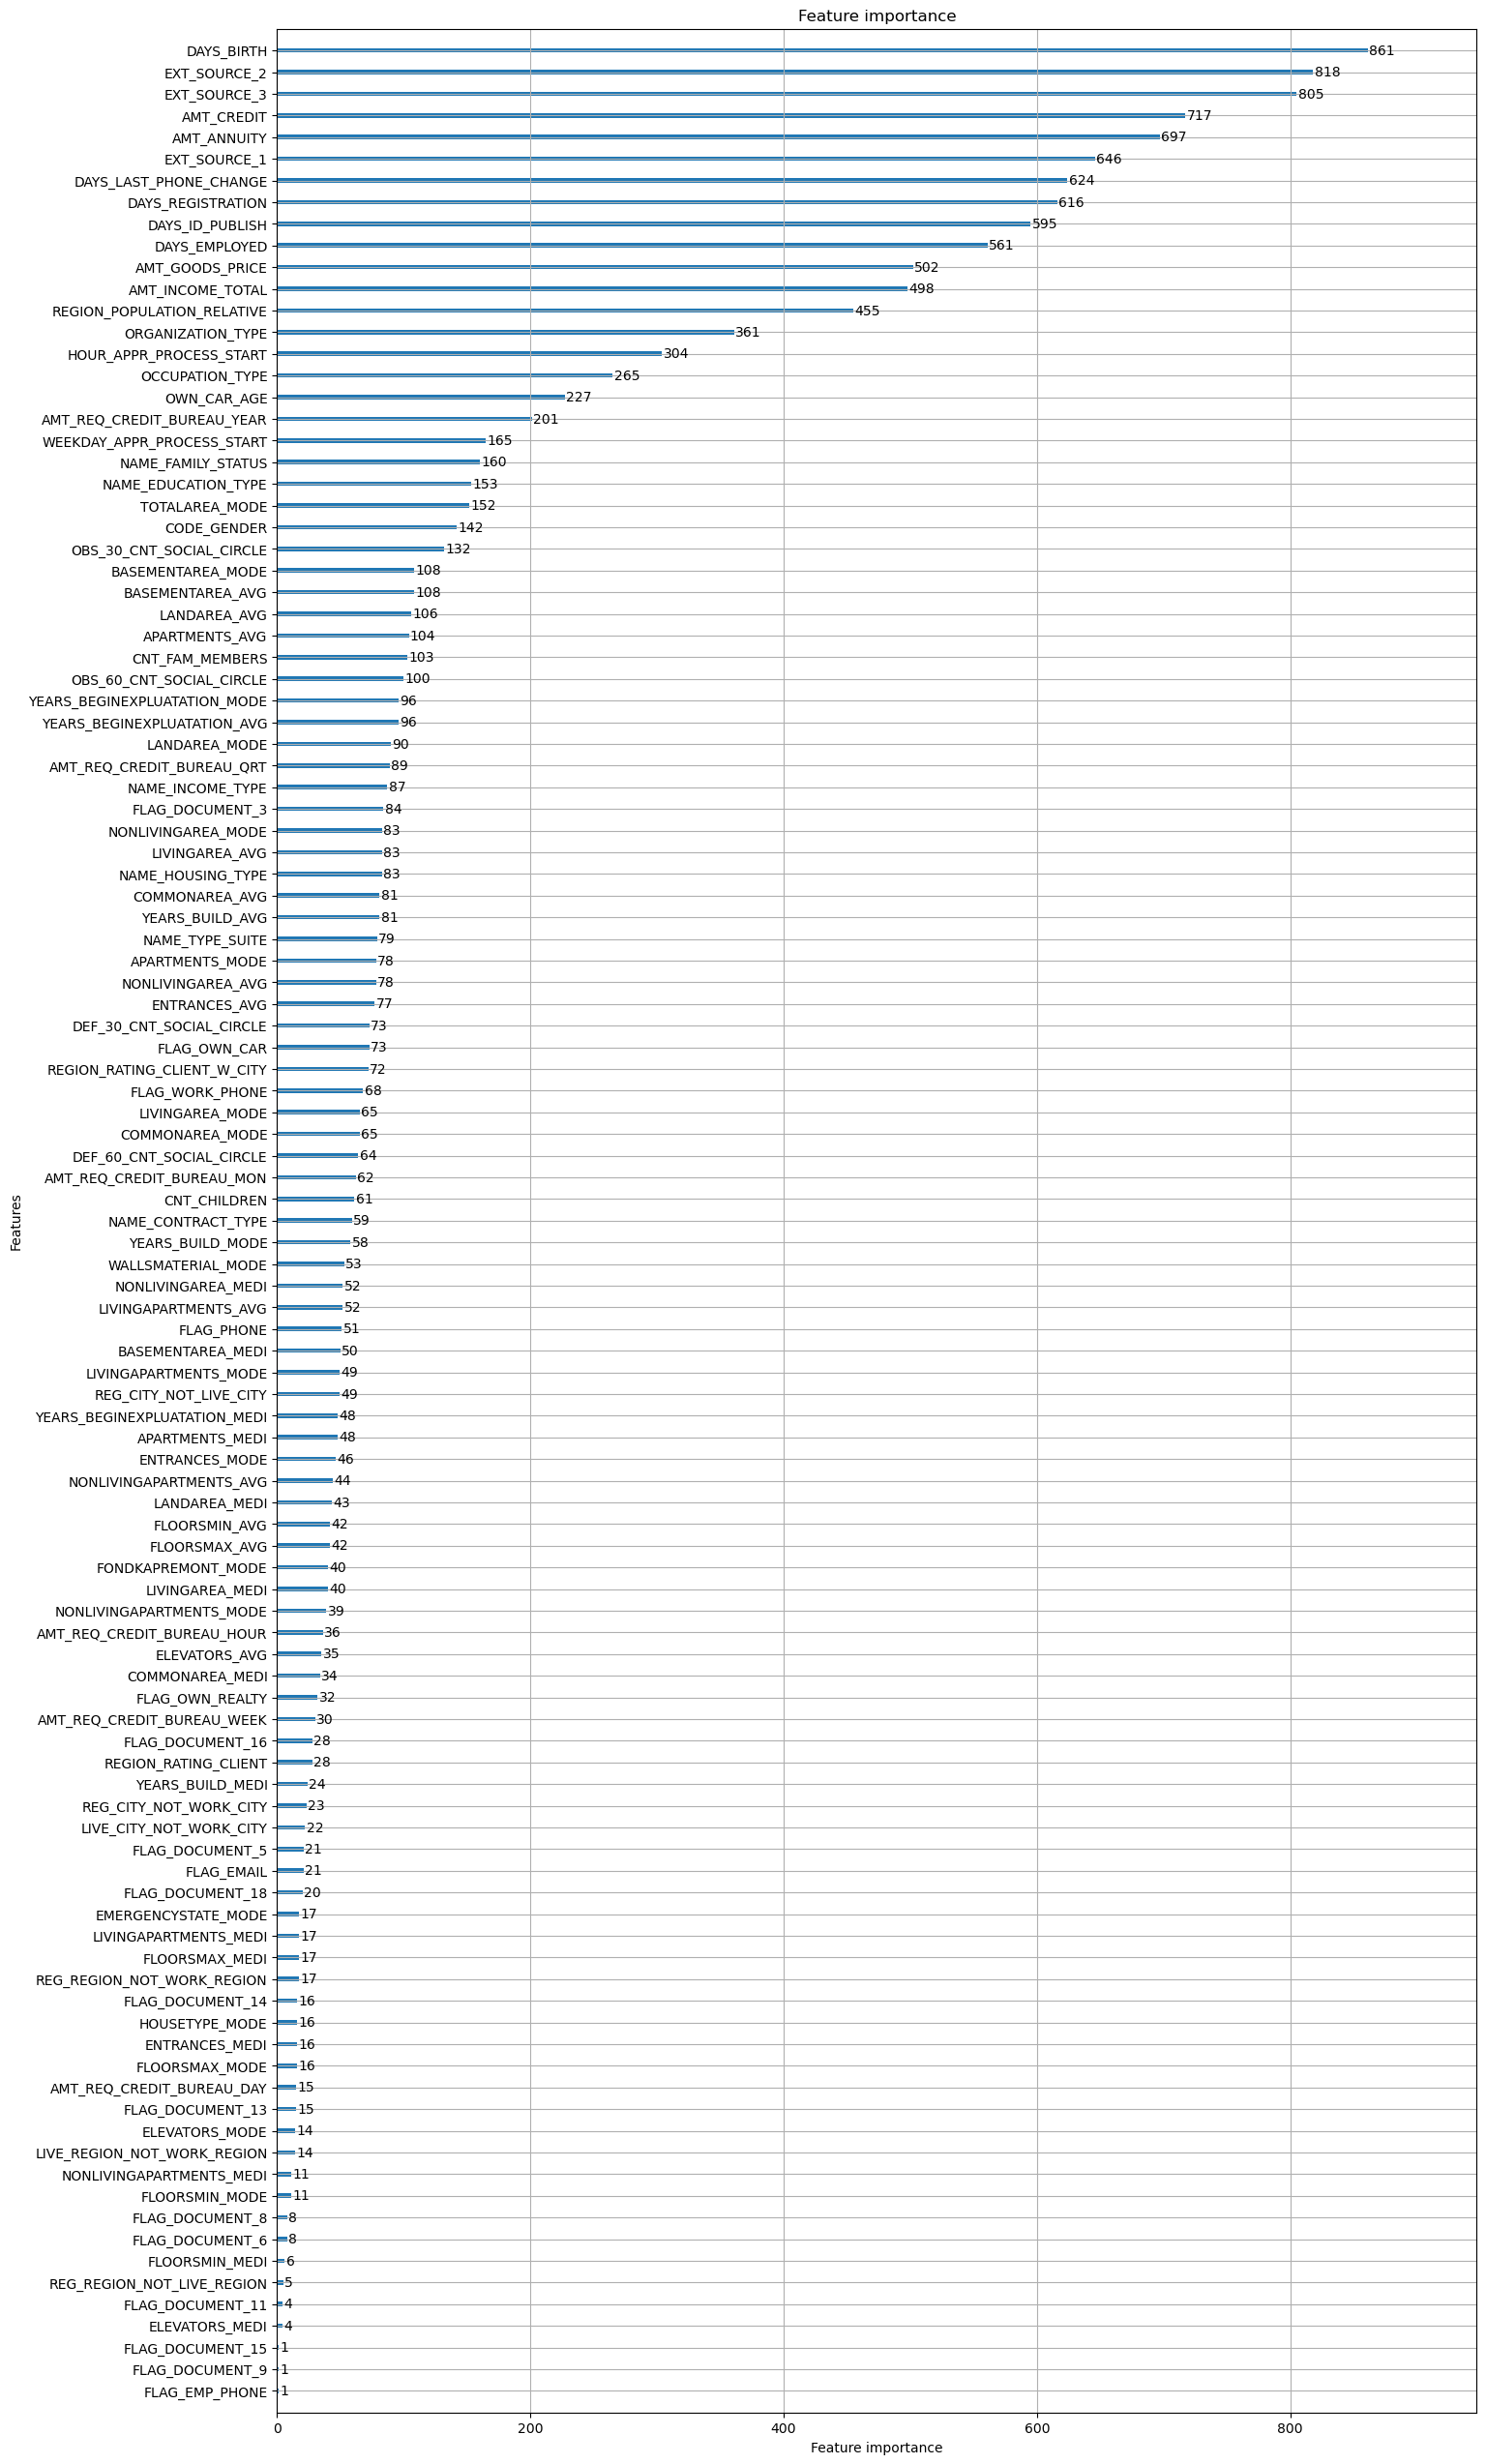

In [14]:
plot_importance(lgb_clf,figsize=(16,32))

- We can see in the graph, which features are relatively important 